# Residual Pseudo W-Net Testing

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20
- Dropout

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc
from metrics import calculate_metrics

Using TensorFlow backend.


In [2]:
# Train and validation data paths
train_path = "/home/ubuntu/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume1/TIFF/Development/Validation/*.tif"
test_path = "/home/ubuntu/volume1/TIFF/Testing/*.tif"

input_train_path = "/home/ubuntu/volume1/TIFF/Development_dct_unet/Training/*.tif"
input_val_path = "/home/ubuntu/volume1/TIFF/Development_dct_unet/Validation/*.tif"
input_test_path = "/home/ubuntu/volume1/TIFF/Testing_dct_unet/*.tif"

# Listing train and validation images
train_images = sorted(glob.glob(train_path))
val_images = sorted(glob.glob(val_path))
test_images = sorted(glob.glob(test_path))

input_train_images = sorted(glob.glob(input_train_path))
input_val_images = sorted(glob.glob(input_val_path))
input_test_images = sorted(glob.glob(input_test_path))

# Summary of images
print("Uncompressed Train set size:", len(train_images))
print("Uncompressed Validation set size:",len(val_images))
print("Uncompressed Testing set size:",len(test_images))

print("DCT U-net Train set size:", len(input_train_images))
print("DCT U-net Validation set size:",len(input_val_images))
print("DCT U-net Testing set size:",len(input_test_images))

Uncompressed Train set size: 10740
Uncompressed Validation set size: 5370
Uncompressed Testing set size: 16110
DCT U-net Train set size: 10740
DCT U-net Validation set size: 5370
DCT U-net Testing set size: 16110


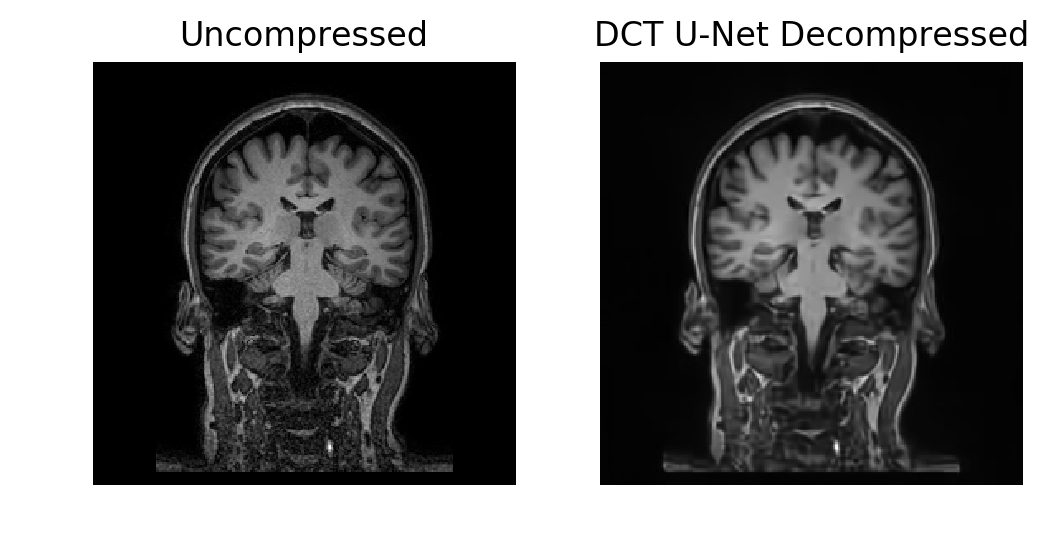

In [3]:
# Load uncompressed image
im1 = Image.open(test_images[300])
im1_array = np.array(im1)

im2 = Image.open(input_test_images[300])
im2_array = np.array(im2)

# buffer2 = io.BytesIO()
# im1_noise.save(buffer2, "JPEG", quality=15)
# im2_noise = Image.open(buffer2)
# im2_noise_array = np.array(im2_noise)

# Display the images
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("DCT U-Net Decompressed")
# plt.subplot(143)
# plt.imshow(im1_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise")
# plt.subplot(144)
# plt.imshow(im2_noise_array,cmap = "gray")
# plt.axis("off")
# plt.title("Uncompr + Gauss Noise Compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0

loadFromFile = False

if loadFromFile:
    test_compr = test_unc.copy()
else:
    test_compr = np.load("../np_imagedata/test_residual_pseudo_wnet_i_data_augmentation_compress_10_20_2019-03-25-pretrained.npy")

test_unc = np.zeros((len(test_images),H,W,1),dtype = np.float32)

for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    if loadFromFile:
        # JPEG compress the image
        im2 = Image.open(input_test_images[ii])
        test_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

test_unc -= 128.0
test_compr -= 128.0
    
test_unc /= 128.0
test_compr /= 128.0

Testing set


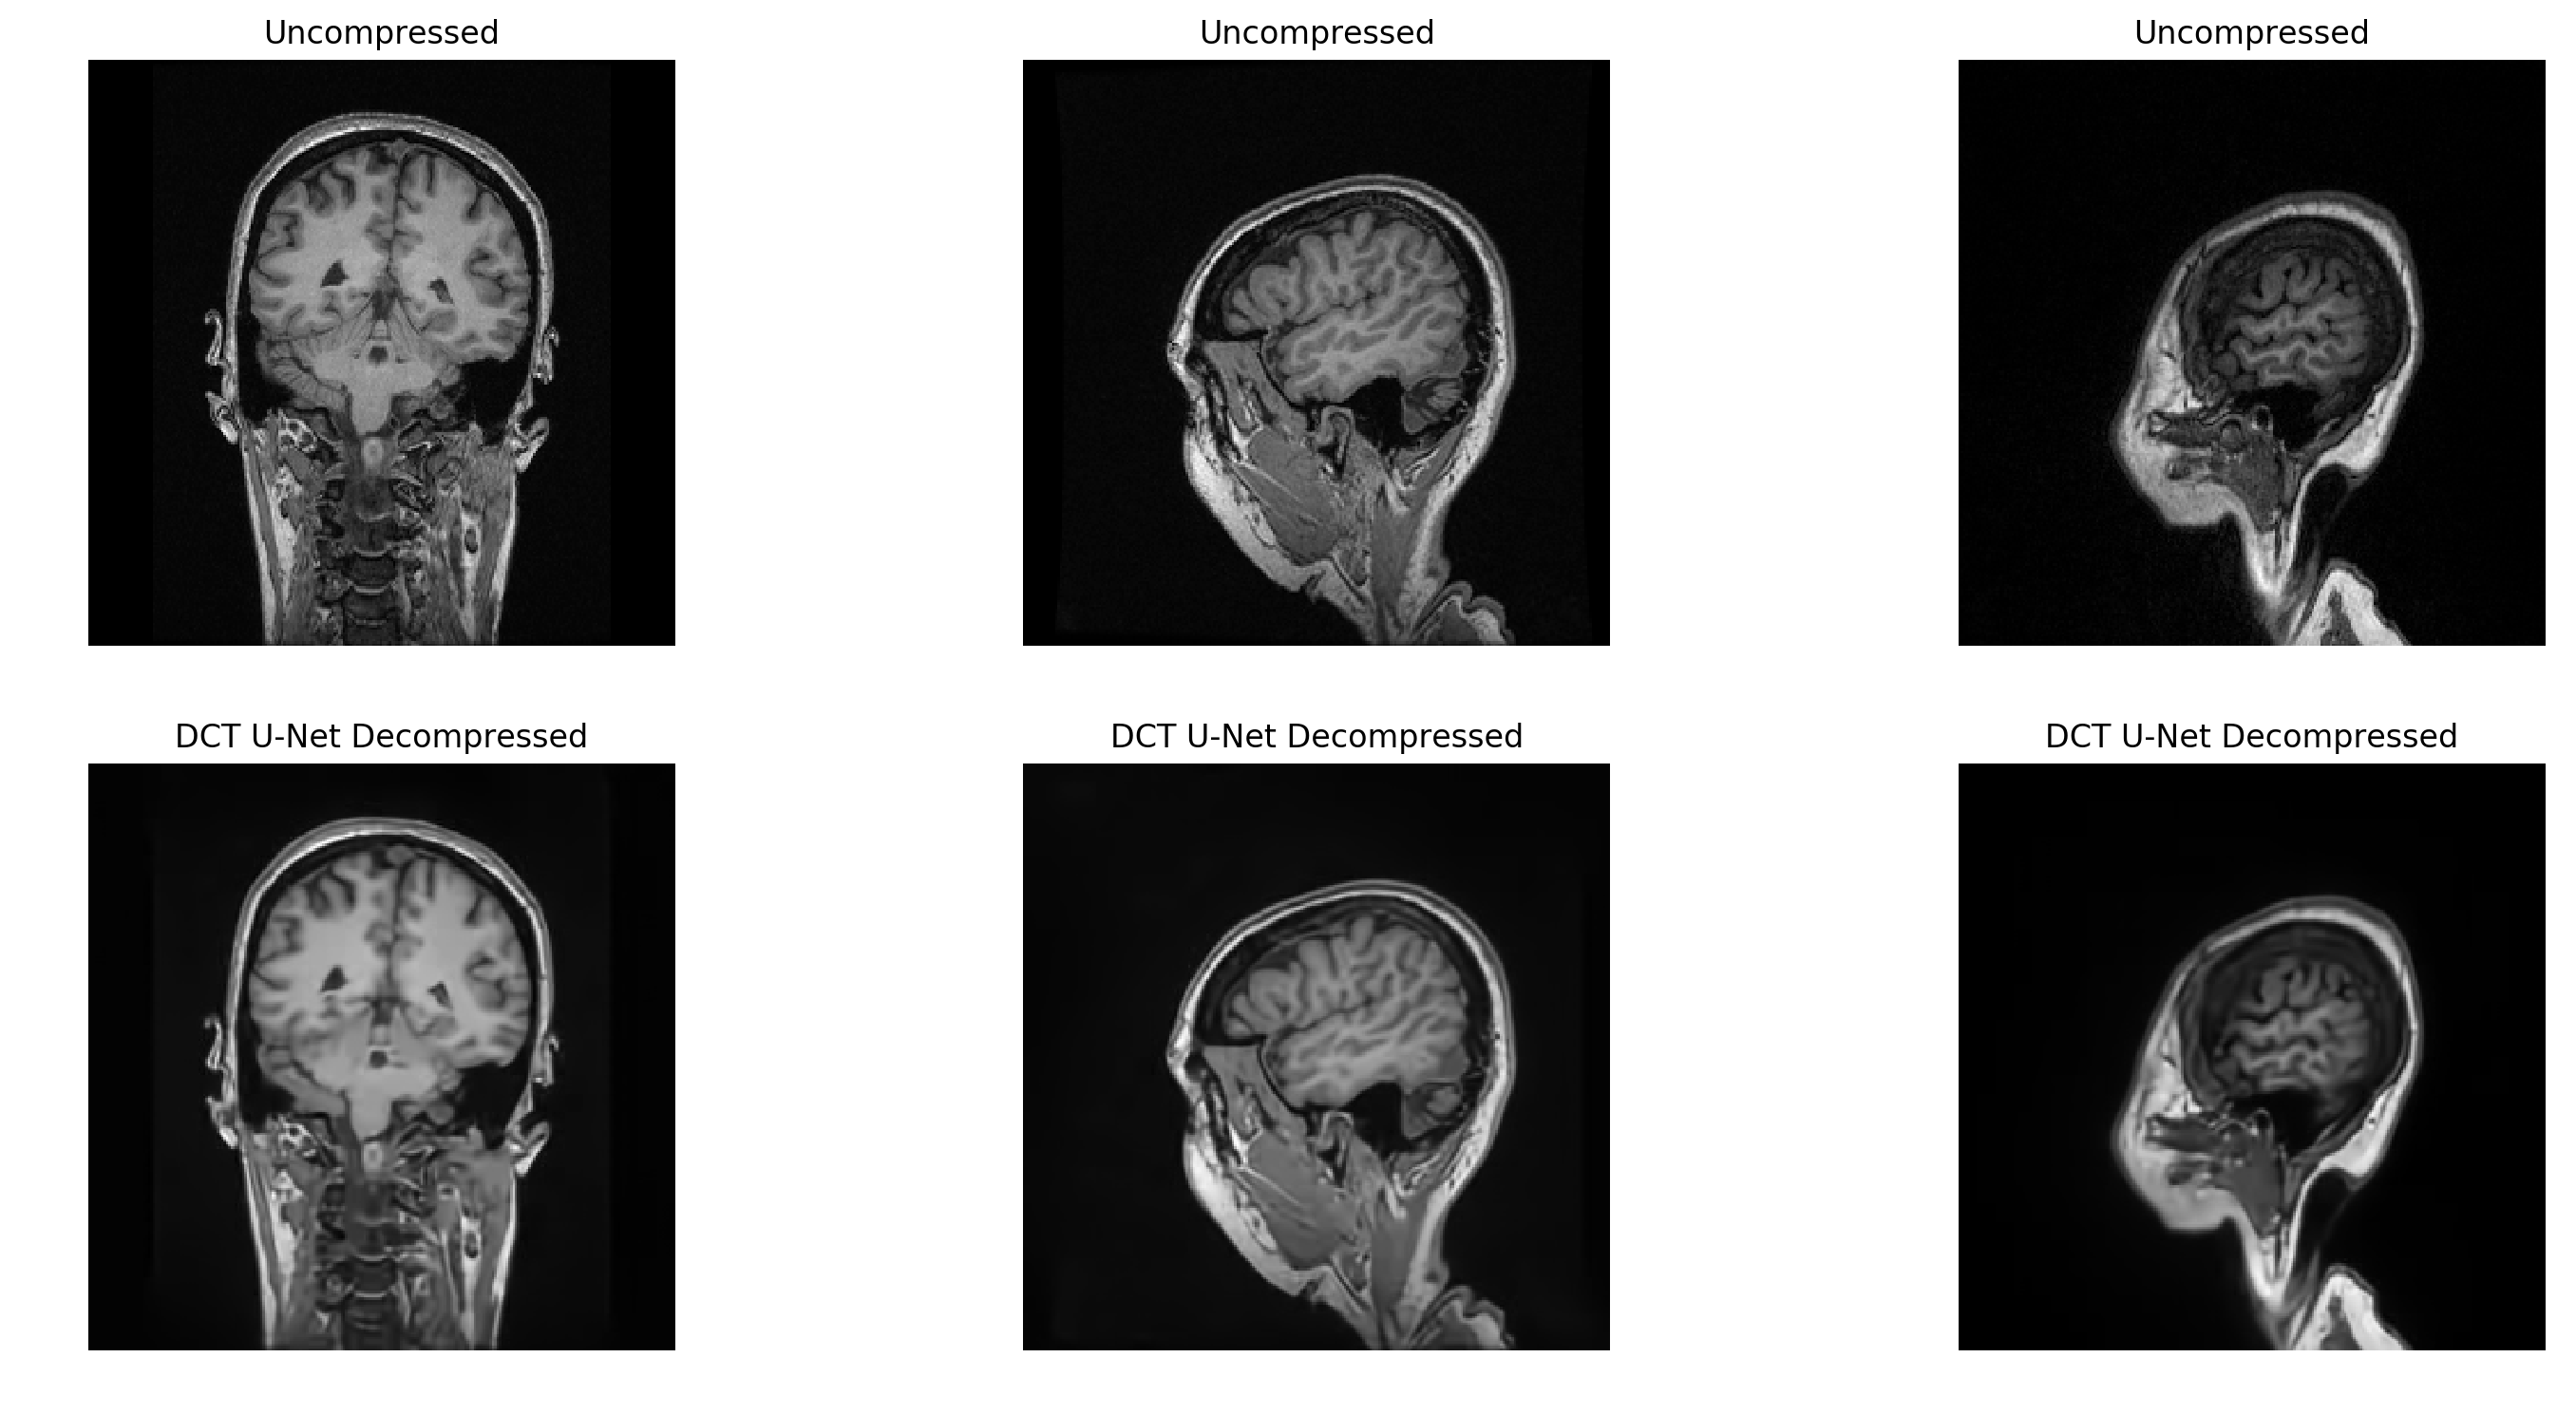

In [5]:
indexes_val = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_val)
indexes_val = indexes_val[:3]

print("Testing set")
plt.figure(figsize=(18,9),dpi=200)
for ii in range(3):
    plt.subplot(2,3,ii+1)
    plt.imshow(test_unc[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed")
    plt.subplot(2,3,ii + 4)
    plt.imshow(test_compr[indexes_val[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("DCT U-Net Decompressed")
plt.show()    

In [6]:
model_name = "../Models/residual_pseudo_wnet_i_data_augmentation_compress_10_20_2019-03-25-pretrained-float-gnoise.hdf5"

opt = Adam(lr=0.0001)
model = deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)
model.load_weights(model_name)

Instructions for updating:
Colocations handled automatically by placer.
0 i
Append U-net block


In [7]:
pred = model.predict(test_compr)

In [8]:
test_unc *= 128.0
test_unc += 128.0

test_compr *= 128.0
test_compr += 128.0

pred *= 128.0
pred += 128.0

0.0 169.0
-3.738617 154.67564


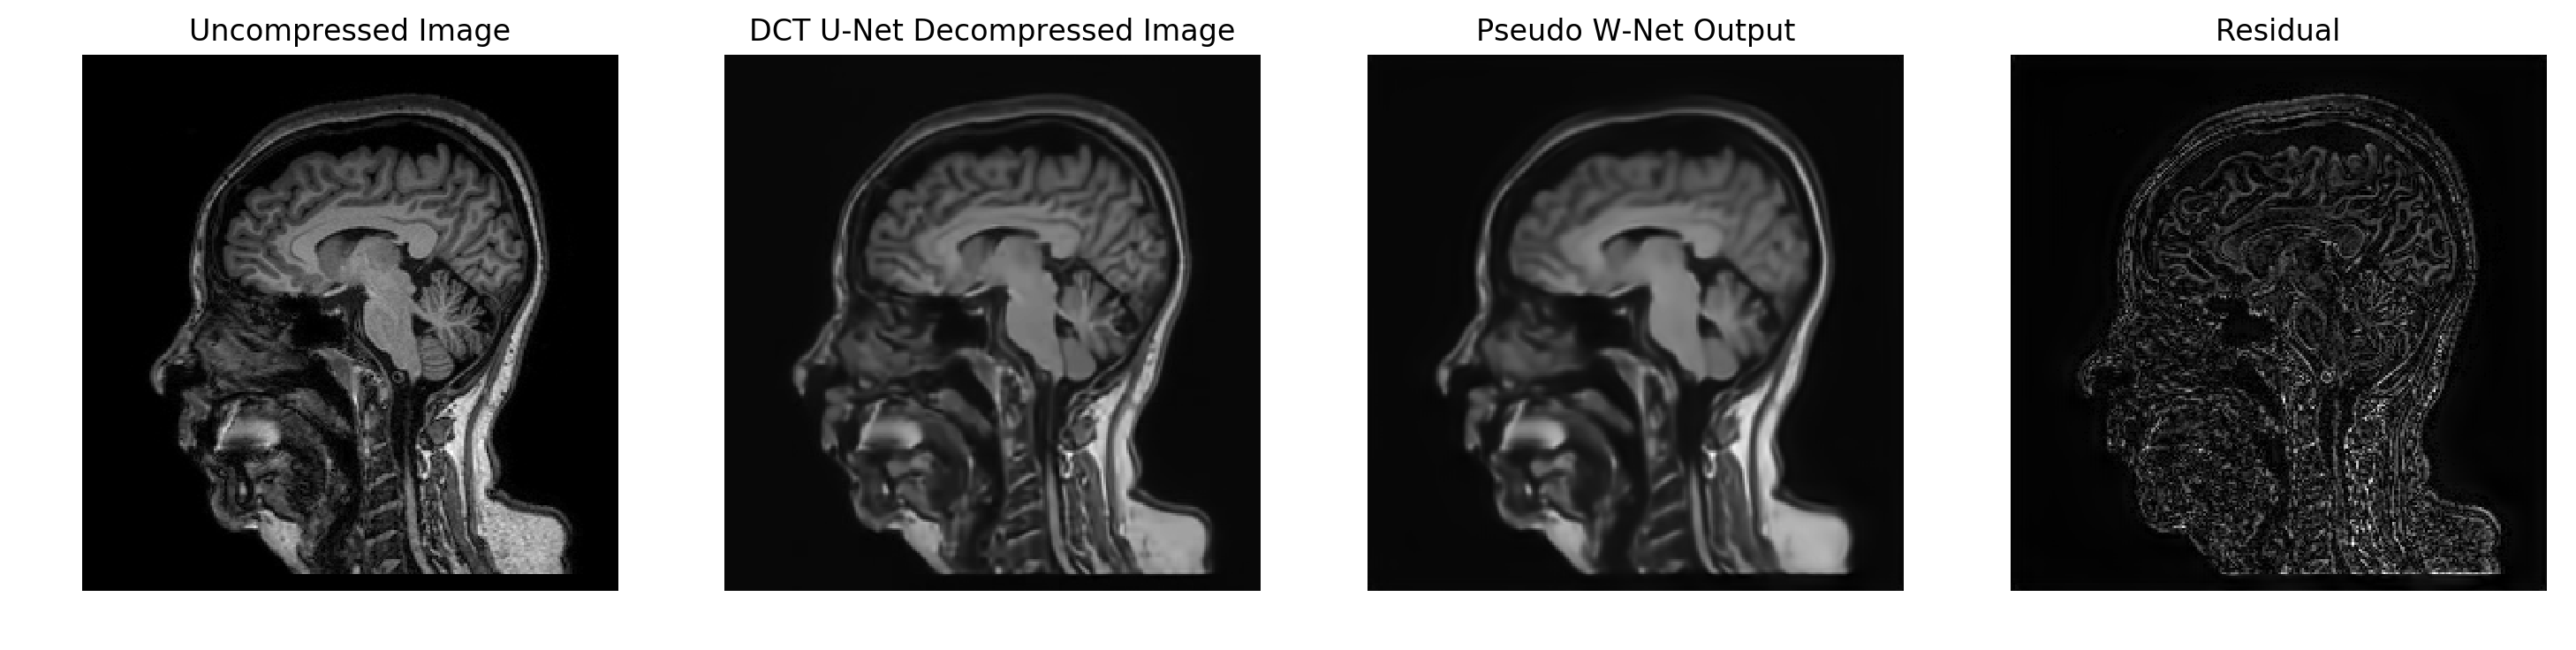

In [9]:
#print(pred)

slc = 65

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[slc,:,:,0]),np.max(pred[slc,:,:,0]))

plt.figure(figsize=(18,9),dpi=200)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("DCT U-Net Decompressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Pseudo W-Net Output")
plt.imshow(pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results
0.0 234.0
-5.021469 183.7921
0.0 178.0
-4.815506 161.02525
0.0 201.0
-1.3979034 156.85712


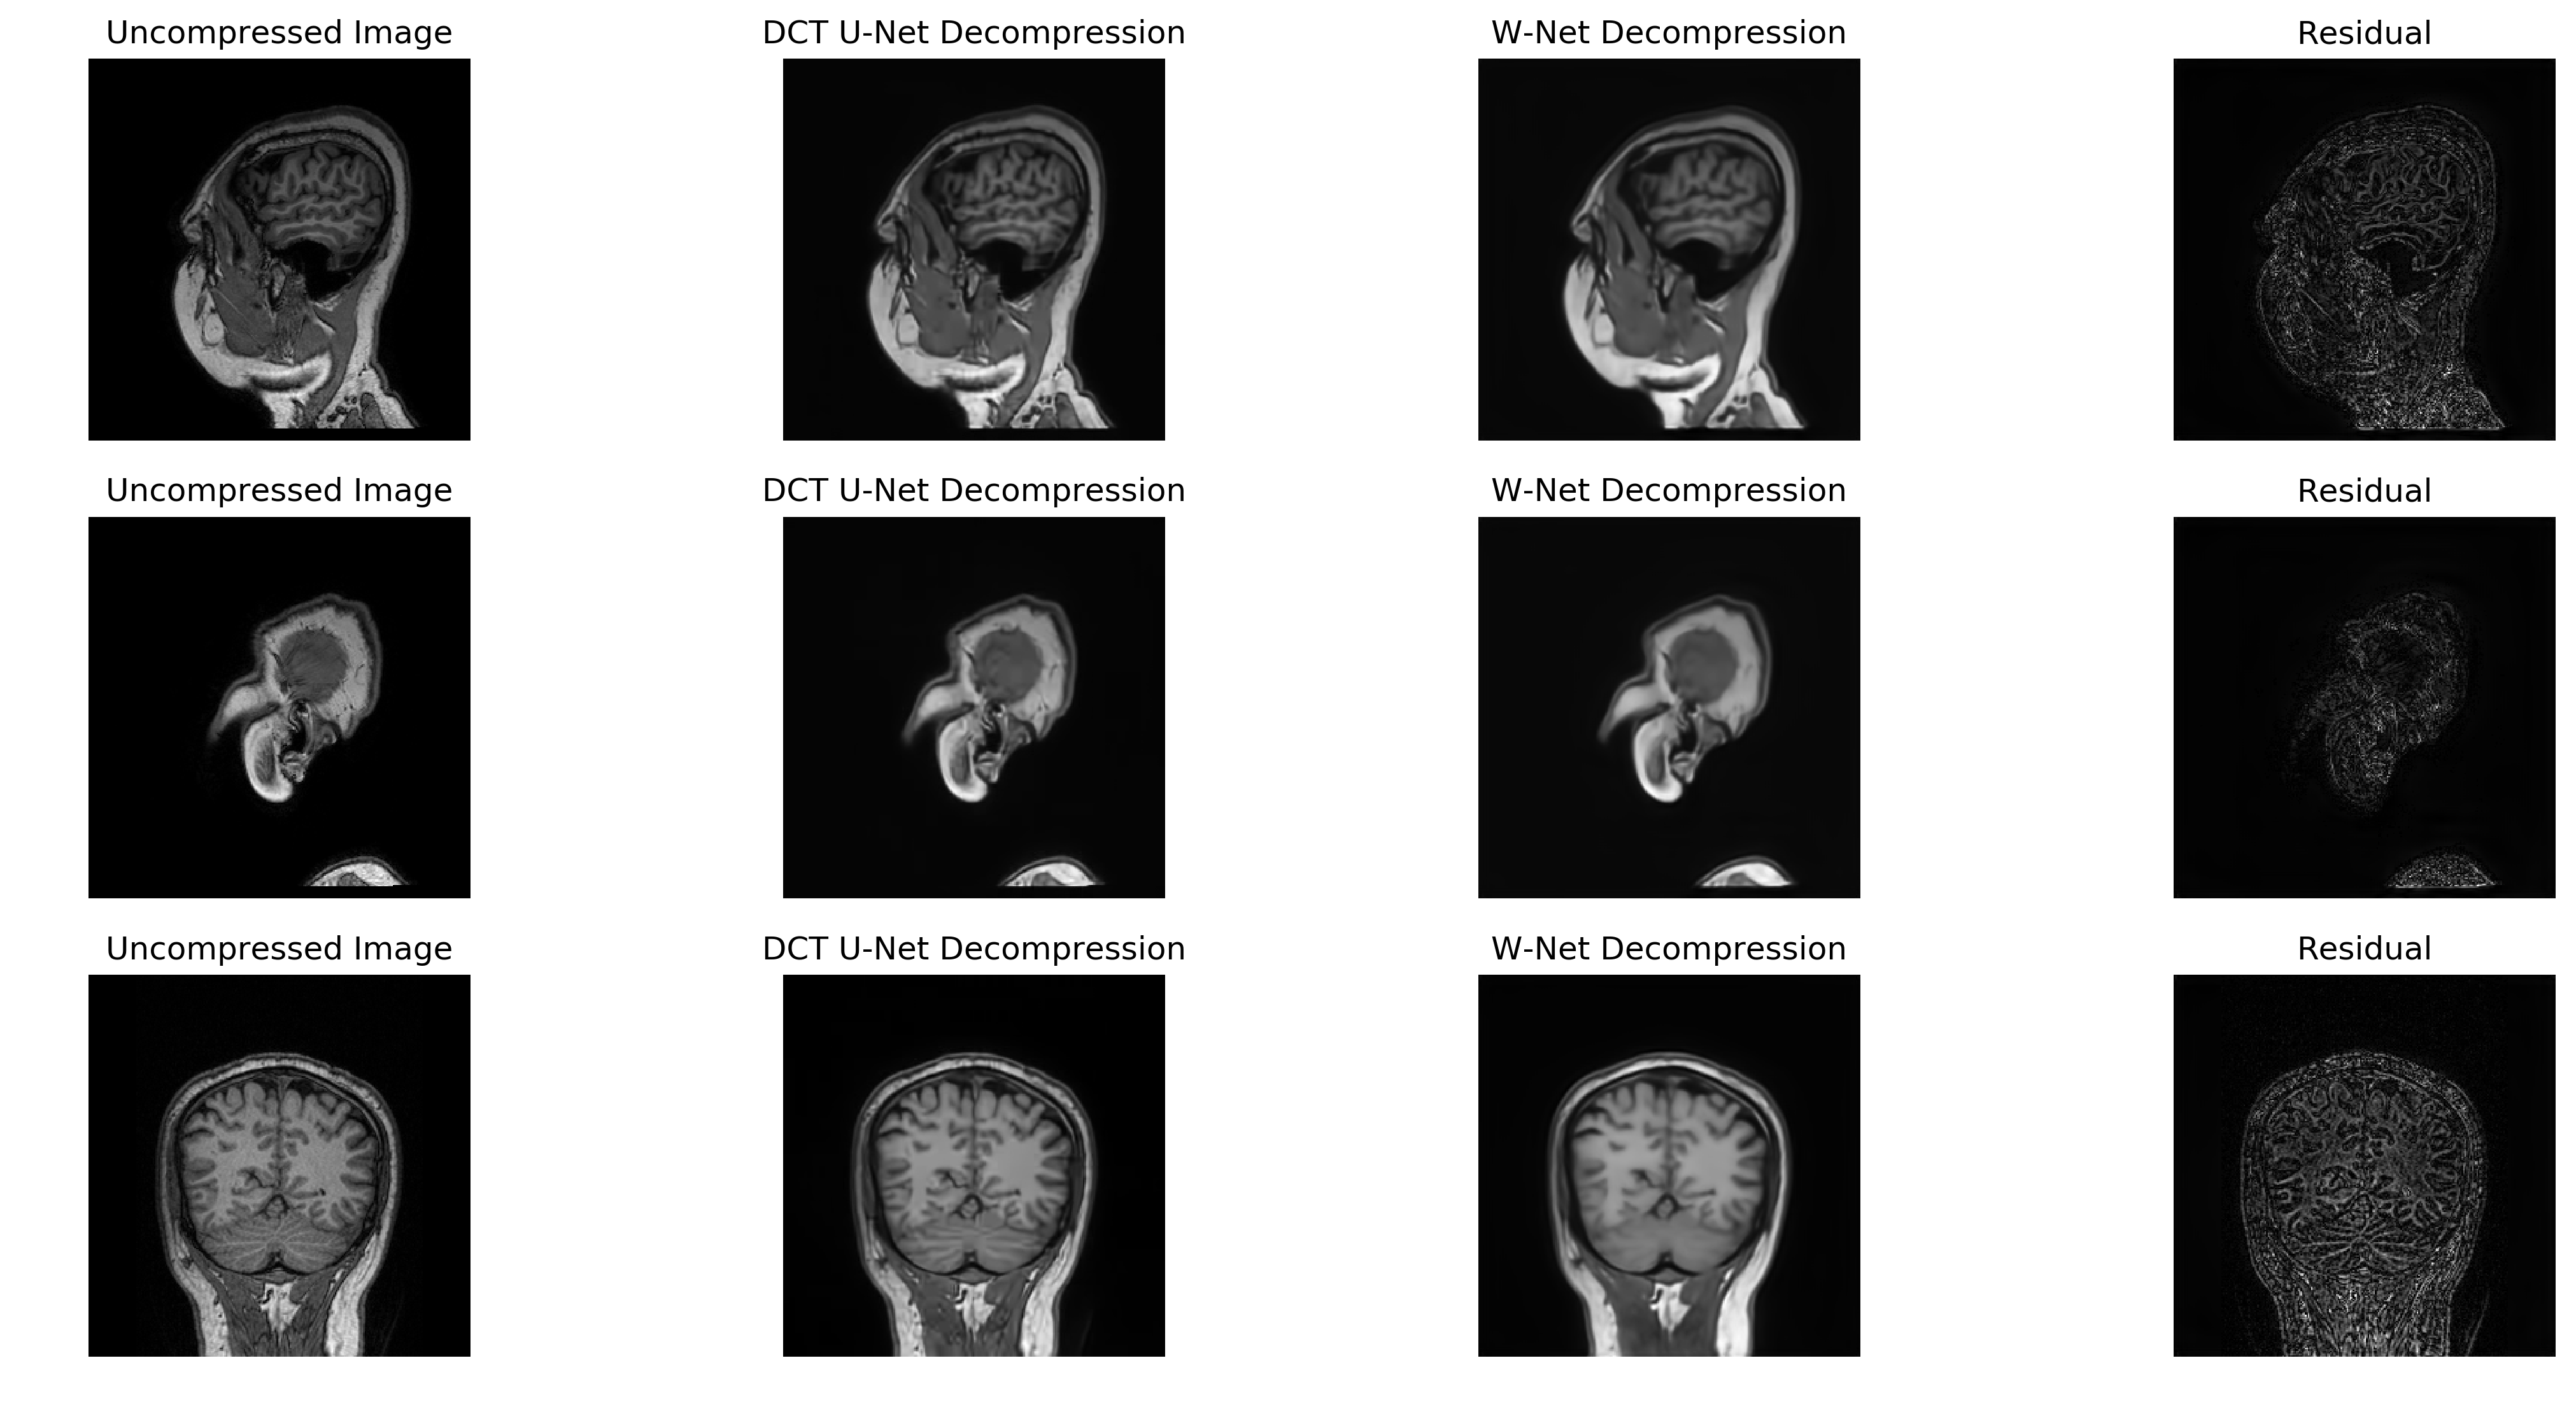

In [10]:
indexes_test = np.arange(len(pred),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize=(18,9),dpi = 300)
for ii in range(3):
    print(np.min(test_unc[indexes_test[ii],:,:,0]),np.max(test_unc[indexes_test[ii],:,:,0]))
    print(np.min(pred[indexes_test[ii],:,:,0]),np.max(pred[indexes_test[ii],:,:,0]))

    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("DCT U-Net Decompression")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("W-Net Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0] - pred[indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

# Performance Metrics

In [11]:
metr = calculate_metrics(test_unc, test_compr, pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from JPEG list.
removing 1715 NRMSE from JPEG list.
removing 1890 NRMSE from JPEG list.
removing 1896 NRMSE from JPEG list.
removing 3240 NRMSE from JPEG list.
removing 3514 NRMSE from JPEG list.
removing 3519 NRMSE from JPEG list.
(16103, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.836 +/- 0.060
PSNR: 30.205 +/- 1.797
NRMSE: 3.013 +/- 0.576


Network Metrics
SSIM: 0.723 +/- 0.073
PSNR: 26.112 +/- 2.039
NRMSE: 4.338 +/- 0.912


In [16]:
metr = np.zeros((len(pred),3,2),dtype=np.float32)
print(metr.shape)

count = 0
for ii in range(len(pred)): 
    
    # Check if the metric values are finite
    # JPEG-Compressed Metrics
    a = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0],data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    if ~np.isfinite(a):
        print("removing %i SSIM from JPEG list." %ii)
        count += 1
        continue
        
    b = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                        data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    if ~np.isfinite(b):
        print("removing %i PSNR from JPEG list." %ii)
        count += 1
        continue
        
    c = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(c):
        print("removing %i NRMSE from JPEG list." %ii)
        count += 1
        continue

    # Network metrics
    d = metrics.compare_ssim(test_unc[ii,:,:,0],pred[ii,:,:,0], data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
    if ~np.isfinite(d):
        print("removing %i SSIM from network list." %ii)
        count += 1
        continue
        
    e = metrics.compare_psnr(test_unc[ii,:,:,0],pred[ii,:,:,0],\
                                       data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
    if ~np.isfinite(e):
        print("removing %i PSNR from network list." %ii)
        count += 1
        continue
        
    f = metrics.compare_nrmse(test_unc[ii,:,:,0],pred[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(f):
        print("removing %i NRMSE from network list." %ii)
        count += 1
        continue
    
    metr[ii,0,0] = a
    metr[ii,1,0] = b
    metr[ii,2,0] = c
    metr[ii,0,1] = d
    metr[ii,1,1] = e    
    metr[ii,2,1] = f
    
# remove empty rows
metr = np.delete(metr,range(len(metr)-count, len(metr)),axis=0)
print(metr.shape)
    
print("\nJPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1629 NRMSE from JPEG list.
removing 1715 NRMSE from JPEG list.
removing 1890 NRMSE from JPEG list.
removing 1896 NRMSE from JPEG list.
removing 3240 NRMSE from JPEG list.
removing 3514 NRMSE from JPEG list.
removing 3519 NRMSE from JPEG list.
(16103, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.836 +/- 0.060
PSNR: 30.205 +/- 1.797
NRMSE: 3.013 +/- 0.576


Network Metrics
SSIM: 0.839 +/- 0.059
PSNR: 30.056 +/- 1.791
NRMSE: 2.996 +/- 0.573
